In [30]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': 'blue', # [31, 157, 90]
    'ACA': 'deepskyblue', # [64, 166, 102]
    'SS': 'blueviolet', # [24, 128, 100]
    'VIS': 'green', # [8, 133, 140]
    'MO-TH': 'steelblue', # [255, 112, 128]
#     'VIS-TH': 'olivedrab'
}

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [11]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

## Load subjects from file

In [12]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [13]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots'

## Choose example subjects and load experiment

In [14]:
example_mice = {
    'MOs_deep': '569073'
}

In [15]:
ex_sub_dict = {x: {} for x in example_mice.keys()}
for group, mouse in example_mice.items():
    print('{} - {}'.format(group, mouse))
    ex_sub_dict[group][mouse] = multi_sub_dict[group][mouse]
    ex_sub_dict[group][mouse]['exp'] = EEGexp(multi_sub_dict[group][mouse]['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_deep - 569073
Experiment type: electrical and sensory stimulation



## Gather data for example subjects

In [16]:
apply_car = True

ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
time_bin = 0.0025 # size of time bins (s)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [17]:
for group, group_subs in ex_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        mdata['data'] = {}
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue
        
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        try:
            bad_chs = mdata['bad_chs']
        except KeyError:
            badchstr = exp_meta['EEG bad_channels'].replace(' ','')
            bad_chs = []
            for char in badchstr.split(','):
                if char.isdecimal():
                    bad_chs.append(int(char))
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)
        if len(currents_list) > 1:
            PCI_stim_amp = currents_list[1]
        elif len(currents_list) == 1:
            PCI_stim_amp = currents_list[0]
        else:
            print('No stim current listed in Zap_Zip-log_exp')

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(evoked_data_folder, 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        mdata['good_chs'] = GOOD_CHS
        
        ## Load LFP info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
            
        ## Load regional stuff ##
        reg_allLFPtraces = {}
        reg_unit_info = {}
        for region in areas_of_interest.keys():
            if region in LFPinfo.keys():
                reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
            if region in ctx_regions:
                regdf = unit_info[(unit_info['cell_type'] == 'RS') & (unit_info['parent'] == region)]
            else:
                regdf = unit_info[unit_info['parent'] == region]
            if len(regdf) > 8:
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
        
        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_inds[leveli] = {}
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                if statei == 'awake':
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    all_event_inds[leveli][statei] = np.concatenate(state_events)
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
                else:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    all_event_inds[leveli][statei] = np.concatenate(state_events)
        
        EEG_traces = {}
        LFP_traces = {}
        unit_traces = {}
        for leveli, states_event_times in all_event_inds.items():
            EEG_traces[leveli] = {}
            LFP_traces[leveli] = {}
            unit_traces[leveli] = {}
            for statei, event_inds in states_event_times.items():
                LFP_traces[leveli][statei] = {}
                unit_traces[leveli][statei] = {}
                ## Get evoked EEG traces ##
                event_traces = all_EEG_traces[:, :, event_inds]
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                EEG_traces[leveli][statei] = [EEG_event_timestamps, event_traces]

                for region in areas_of_interest.keys():
                    ## Get evoked LFP traces ##
                    if region in reg_allLFPtraces.keys():
                        LFP_traces[leveli][statei][region] = [LFP_event_ts, reg_allLFPtraces[region][:, :, event_inds]]

                    ## Get unit z-score ##
                    if region in reg_unit_info.keys():
                        unit_firing_rates = np.zeros((len(timex), len(reg_unit_info[region])), dtype=float) * np.nan
                        for ii, unitrow in reg_unit_info[region].iterrows():
                            unit_event_spikes = [
                                all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                            unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
                            unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))
                        unit_traces[leveli][statei][region] = [timex, get_zFR(unit_firing_rates, timex)]
        
        mdata['data']['EEG'] = EEG_traces
        mdata['data']['LFP'] = LFP_traces
        mdata['data']['unit_zscores'] = unit_traces
        
        ### After each subject, delete common variables ###
        del stim_log
        del all_EEG_traces, EEG_event_timestamps
        del reg_allLFPtraces, LFP_event_ts, LFPinfo
        del unit_info, all_unit_event_spikes, reg_unit_info
        del EEG_traces, LFP_traces, unit_traces
    print('')

MOs_deep
 569073



### Make EEG array plot w/ PCI

In [88]:
PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

In [91]:
exmouse = '569073'
exgroup = 'MOs_deep'
plevel = 'medium'
pstates = {'resting': 'k', 'anesthetized': 'orange'}

EEG_traces = multi_sub_dict[exgroup][exmouse]['data']['EEG'][plevel]
NUM_TRIALS = min([EEG_traces[x][1].shape[2] for x in pstates.keys()])

leglabels = []
for statei, labeli in zip(pstates.keys(), ['awake', 'anest']):
    timex = EEG_traces[statei][0]
    traces = np.mean(EEG_traces[statei][1][:, :, :NUM_TRIALS], axis=2)
    
    ## PCI calculation ##
    statePCI = calc_PCIst(traces[:, multi_sub_dict[exgroup][exmouse]['good_chs']].T, timex, full_return=False, **PCI_params)
    leglabels.append('{} (PCIst={:.2f})'.format(labeli, statePCI))

<IPython.core.display.Javascript object>


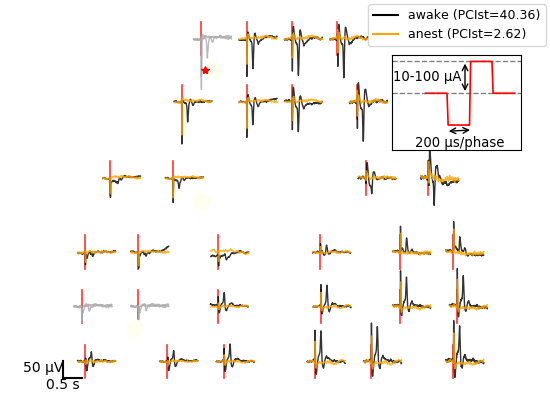

In [100]:
plwin = [-0.2, 0.8]
xmult = 1.2
ymult = 150 # 250 for VEPs: 100
bregma_ann = {'xycoords': 'data', 'textcoords': 'data', 'arrowprops': dict(arrowstyle='<-', lw=1)}

## Create stim wave for inset ##
xvals = np.arange(-0.2, 0.6, 0.01)
yvals = np.zeros_like(xvals)
yvals[np.nonzero((xvals > 0) & (xvals <= 0.2))[0]] = -1
yvals[np.nonzero((xvals > 0.2) & (xvals <= 0.4))[0]] = 1

fig, ax = plt.subplots(figsize=(5.5, 4), constrained_layout=True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

for jj, (statei, stcoli) in enumerate(pstates.items()):
    timex = EEG_traces[statei][0]
    traces = np.mean(EEG_traces[statei][1][:, :, :NUM_TRIALS], axis=2)
    pinds = np.nonzero((timex >= plwin[0]) & (timex <= plwin[1]))[0]

    for chi in range(traces.shape[1]):
        if chi in multi_sub_dict[exgroup][exmouse]['good_chs']:
            chcolor = stcoli
        else:
            chcolor = 'darkgray'
        if chi == 0:
            llabel = statei
        else:
            llabel = None
        if jj == 0:
            ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
                     0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
                    [-50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
                     50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
                    color='r', linewidth=1.2, alpha=0.8, label=None)
        ax.plot(
            timex[pinds] + (EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
            traces[pinds, chi] + (EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
            color=chcolor, linewidth=1.0, alpha=0.8, label=llabel
        )

        if (jj == 0) & (chi == 0):
            mx = timex[0] + EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * 0.85
            my = EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## Scale bar ##
x_len = .5 # x scale bar length in s
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Add symbols for stim, NPXs, and bregma ##
# ax.annotate('A', xy=(0,0), xytext=(0,70), ha='center', va='bottom', **bregma_ann)
# ax.annotate('P', xy=(0,0), xytext=(0,-70), ha='center', va='top', **bregma_ann)
# ax.annotate('L', xy=(0,0), xytext=(-0.8,0), ha='left', va='center', **bregma_ann)
# ax.annotate('R', xy=(0,0), xytext=(0.8,0), ha='right', va='center', **bregma_ann)
# ax.plot([-1.5, -1.8, -3.55], [250, -140, -520], marker='X', color='b', linestyle='none')
ax.plot([-1.5, -1.8, -3.55], [250, -140, -520], marker='o', markersize=12, color='ivory', linestyle='none')
ax.plot([-1.7], [250], marker='*', color='r') #, label='stim')
ax.set_xlim([-7, 6])
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Add stim inset ##
axins = inset_axes(ax, width="25%", height="28%",
                   bbox_to_anchor=(0,0,1.05,0.87), bbox_transform=ax.transAxes, loc=1, borderpad=0)
axins.axhline(0, color='gray', linewidth=1, linestyle='dashed')
axins.axhline(1, color='gray', linewidth=1, linestyle='dashed')
axins.plot(xvals, yvals, color='r', linewidth=1.2)
axins.set_xlim([-0.5, 0.65])
axins.set_ylim([-1.8, 1.2])
axins.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
axins.annotate('', xy=(0.15, -0.02), xytext=(0.15, 1.02), arrowprops=dict(arrowstyle='<->'))
axins.annotate('10-100 \u03bcA', xy=(0.12, 0.5), ha='right', va='center', annotation_clip=False, fontsize=9.5)
axins.annotate('', xy=(-0.02, -1.2), xytext=(0.22, -1.15), arrowprops=dict(arrowstyle='<->'))
axins.annotate('200 \u03bcs/phase', xy=(0.1, -1.35), ha='center', va='top', annotation_clip=False, fontsize=9.5)
axins.set_facecolor('w')

## Make a legend ##
leghandles = []
for (statei, stcoli), labeli in zip(pstates.items(), leglabels):
    leghandles.append(Line2D([],[], color=stcoli, label=labeli))
ax.legend(handles=leghandles, prop={'size': 9}, bbox_to_anchor=(1.1,1), borderaxespad=0, loc='upper right') # , loc='upper right'

## Save ##
figname = '{}_{}_arrayERP_badchgray_inset.png'.format(exgroup, exmouse)
fig.savefig(os.path.join(plotsdir, figname), transparent=True, dpi=300)

### Plot figure 2: two subjects examples with EEG and unit zscores for AWAKE only

<IPython.core.display.Javascript object>


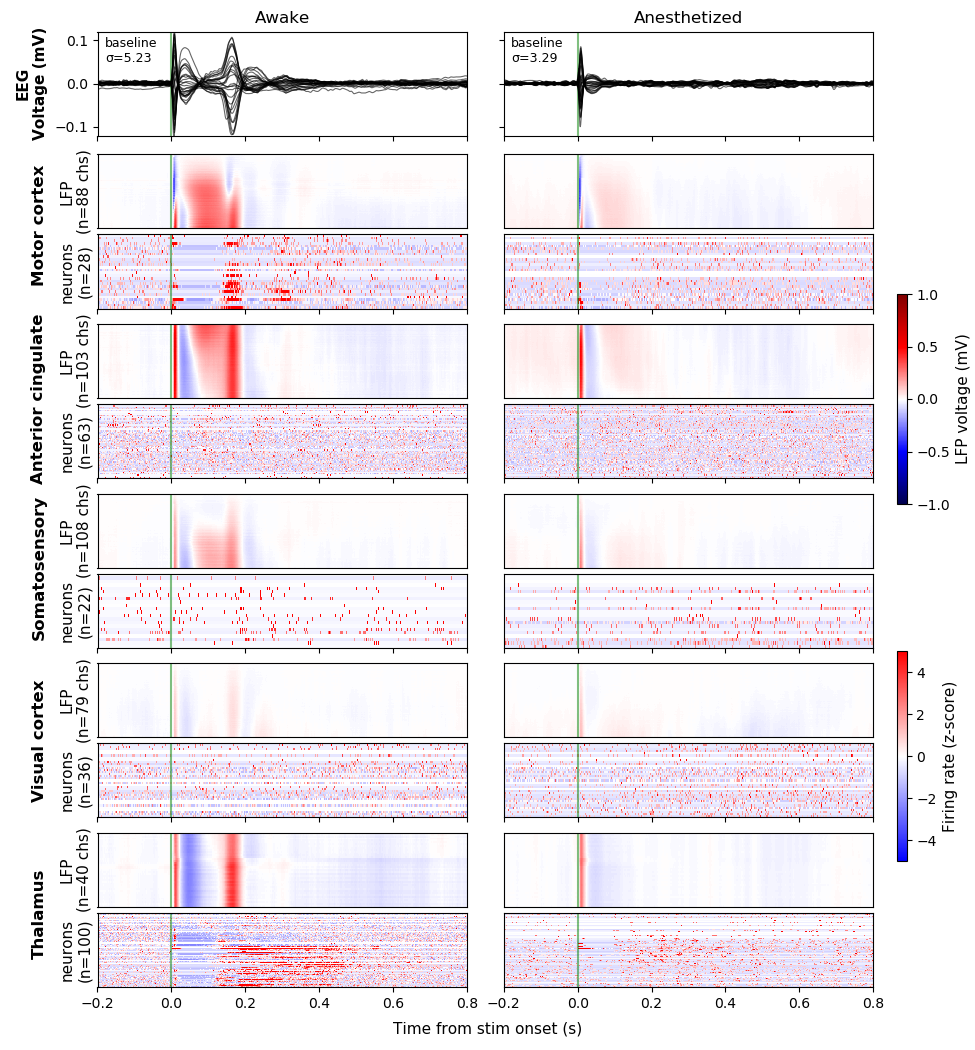

In [119]:
plwin = [-0.2, 0.8]
eeg_ylim = [-0.12, 0.12]
vlevel = 1.0
Zlim = 5

fig = plt.figure(figsize=(9.75, 10.5))
gs = fig.add_gridspec(
    ncols=2, nrows=2, height_ratios=[1, 8], width_ratios=[1, 0.08], left=0.1, right=0.985, top=0.97, bottom=0.06,
    wspace=0.06, hspace=0.04)
EEGgs = gs[0,0].subgridspec(ncols=len(pstates), nrows=1, wspace=0.1)
EEGaxs = [fig.add_subplot(ss) for ss in EEGgs]
NPXgs = gs[1,0].subgridspec(ncols=len(pstates), nrows=len(areas_of_interest), hspace=0.1, wspace=0.1)

for jj, (statei, stcoli) in enumerate(pstates.items()):
    EEG_traces = ex_sub_dict[group][mouse]['data']['EEG'][plevel]
    LFP_traces = ex_sub_dict[group][mouse]['data']['LFP'][plevel]
    unitZ = ex_sub_dict[group][mouse]['data']['unit_zscores'][plevel]
    GOOD_CHS = ex_sub_dict[group][mouse]['good_chs']
    
    ## Plot EEG traces ##
    EEGaxs[jj].axvline(0, color='g', alpha=0.5)
    EEGaxs[jj].plot(
        EEG_traces[statei][0], np.mean(EEG_traces[statei][1][:, GOOD_CHS, :NUM_TRIALS], axis=2) / 1E3, 'k', linewidth=0.8, alpha=0.6)
    EEGaxs[jj].set_xlim(plwin)
    EEGaxs[jj].set_xticklabels([])
    EEGaxs[jj].set_ylim(eeg_ylim)
    if jj == 0:
        EEGaxs[jj].set_ylabel('EEG\nVoltage (mV)', fontsize=11, fontweight='bold')
    BLstd = np.std(np.mean(EEG_traces[statei][1][:, GOOD_CHS, :], axis=2)[EEG_traces[statei][0] < 0, :])
    EEGaxs[jj].annotate(
        'baseline\n\u03c3={:.2f}'.format(BLstd), xy=(0.02, 0.95), xycoords='axes fraction', fontsize=9, ha='left', va='top'
    )

    ## Plot unit z-score activity ##
    for kk, region in enumerate(areas_of_interest.keys()):
        if region not in unitZ[statei].keys():
            continue
        NPXdual = NPXgs[kk,jj].subgridspec(nrows=2, ncols=1, hspace=0.08)
        NPXaxs = [fig.add_subplot(ss) for ss in NPXdual]
        ## LFP ##
        imlfp = NPXaxs[0].imshow(
            np.mean(LFP_traces[statei][region][1], axis=2).T / 1E3, cmap='seismic', #'bwr'
            interpolation='none', aspect='auto', origin='upper', vmin=-vlevel, vmax=vlevel,
            extent=[LFP_traces[statei][region][0][0], LFP_traces[statei][region][0][-1],
                    LFP_traces[statei][region][1].shape[1], 0]
        )
        NPXaxs[0].set_xlim(plwin)
        NPXaxs[0].axvline(0, color='g', alpha=0.5)
        NPXaxs[0].set_xticks([])
        NPXaxs[0].set_xticklabels([])
        NPXaxs[0].set_yticks([])
        ## Z-scores ##
        imunit = NPXaxs[1].imshow(
            unitZ[statei][region][1].T, cmap='bwr',
            interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[unitZ[statei][region][0][0], unitZ[statei][region][0][-1], 0, unitZ[statei][region][1].shape[0]],
        )
        NPXaxs[1].set_xlim(plwin)
        NPXaxs[1].axvline(0, color='g', alpha=0.5)
        if kk < len(areas_of_interest)-1:
            NPXaxs[1].set_xticklabels([])
        NPXaxs[1].set_yticks([])
        if jj == 0:
#             NPXaxs[0].set_ylabel('LFP', fontsize=11)
            NPXaxs[0].set_ylabel('LFP\n(n={:d} chs)'.format(LFP_traces[statei][region][1].shape[1]), fontsize=11)
            NPXaxs[1].set_ylabel('neurons\n(n={:d})'.format(unitZ[statei][region][1].shape[1]), fontsize=11)

fig.text(0.04, 0.785, 'Motor cortex', rotation='vertical', va='center', ha='center', fontsize=12, fontweight='bold')
fig.text(0.04, 0.62, 'Anterior cingulate', rotation='vertical', va='center', ha='center', fontsize=12, fontweight='bold')
fig.text(0.04, 0.46, 'Somatosensory', rotation='vertical', va='center', ha='center', fontsize=12, fontweight='bold')
fig.text(0.04, 0.295, 'Visual cortex', rotation='vertical', va='center', ha='center', fontsize=12, fontweight='bold')
fig.text(0.04, 0.13, 'Thalamus', rotation='vertical', va='center', ha='center', fontsize=12, fontweight='bold')
                
fig.text(0.5, 0.02, 'Time from stim onset (s)', va='center', ha='center', fontsize=11)

EEGaxs[0].set_title('Awake', fontsize=12)
EEGaxs[1].set_title('Anesthetized', fontsize=12)
EEGaxs[1].set_yticklabels([])

## Add the colorbar ##
cbgs = gs[1,1].subgridspec(nrows=2, ncols=1, hspace=0.2)

lcbax = plt.subplot(cbgs[0], position=[0.92, 0.52, 0.01, 0.2])
lcb = Colorbar(ax=lcbax, mappable=imlfp, orientation='vertical', ticklocation='right')
lcb.set_label('LFP voltage (mV)', fontsize=11)

ucbax = plt.subplot(cbgs[1], position=[0.92, 0.18, 0.01, 0.2])
ucb = Colorbar(ax=ucbax, mappable=imunit, orientation='vertical', ticklocation='right')
ucb.set_label('Firing rate (z-score)', fontsize=11)

## Save ##
figname = 'evoked_EEG_LFP_unitZ_aw-an.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

Plot for SAC meeting slides

<IPython.core.display.Javascript object>


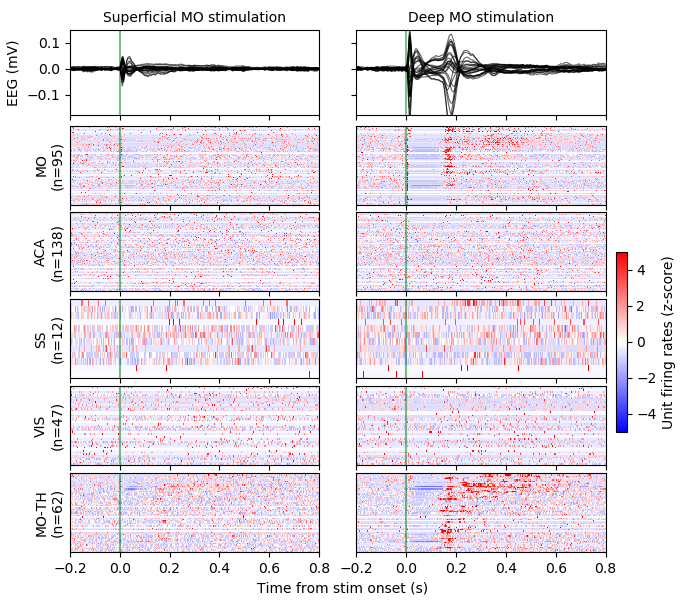

In [33]:
plwin = [-0.2, 0.8]
eeg_ylim = [-0.18, 0.15]
vlevel = 0.8
Zlim = 5
plevel = 'medium'
statei = 'resting'

fig = plt.figure(figsize=(7, 6))
gs = fig.add_gridspec(
    ncols=2, nrows=2, height_ratios=[1, 5], width_ratios=[1, 0.02], left=0.1, right=0.9, top=0.95, bottom=0.08,
    wspace=0.05, hspace=0.04)
EEGgs = gs[0,0].subgridspec(ncols=len(example_mice), nrows=1, wspace=0.15)
EEGaxs = [fig.add_subplot(ss) for ss in EEGgs]
NPXgs = gs[1,0].subgridspec(ncols=len(example_mice), nrows=len(areas_of_interest), hspace=0.1, wspace=0.15)

for ii, (group, mouse) in enumerate(example_mice.items()):
    EEG_traces = ex_sub_dict[group][mouse]['data']['EEG'][plevel]
    LFP_traces = ex_sub_dict[group][mouse]['data']['LFP'][plevel]
    unitZ = ex_sub_dict[group][mouse]['data']['unit_zscores'][plevel]
    GOOD_CHS = ex_sub_dict[group][mouse]['good_chs']
    
    coli = ii
    ## Plot EEG traces ##
    EEGaxs[coli].axvline(0, color='g', alpha=0.5)
    EEGaxs[coli].plot(
        EEG_traces[statei][0], np.mean(EEG_traces[statei][1][:, GOOD_CHS, :], axis=2) / 1E3, 'k', linewidth=0.8, alpha=0.6)
    EEGaxs[coli].set_xlim(plwin)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_ylim(eeg_ylim)
    if coli == 0:
        EEGaxs[coli].set_ylabel('EEG (mV)')
    else:
        EEGaxs[coli].set_yticklabels([])

    ## Plot unit z-score activity ##
    for kk, region in enumerate(areas_of_interest.keys()):
        if region not in unitZ[statei].keys():
            continue
        NPXax = fig.add_subplot(NPXgs[kk,coli])
        ## Z-scores ##
        imunit = NPXax.imshow(
            unitZ[statei][region][1].T, cmap='bwr',
            interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[unitZ[statei][region][0][0], unitZ[statei][region][0][-1], 0, unitZ[statei][region][1].shape[0]],
        )
        NPXax.set_xlim(plwin)
        NPXax.axvline(0, color='g', alpha=0.5)
        if kk < len(areas_of_interest)-1:
            NPXax.set_xticklabels([])
        NPXax.set_yticks([])
        if coli == 0:
            NPXax.set_ylabel('{}\n(n={:d})'.format(region, unitZ[statei][region][1].shape[1]))#, fontsize=14)

# fig.text(0.02, 0.78, 'MO', rotation='vertical', va='center', ha='center', fontsize=12)
# fig.text(0.02, 0.62, 'ACA', rotation='vertical', va='center', ha='center', fontsize=12)
# fig.text(0.02, 0.46, 'SS', rotation='vertical', va='center', ha='center', fontsize=12)
# fig.text(0.02, 0.29, 'VIS', rotation='vertical', va='center', ha='center', fontsize=12)
# fig.text(0.02, 0.14, 'TH', rotation='vertical', va='center', ha='center', fontsize=12)
                
fig.text(0.49, 0.02, 'Time from stim onset (s)', va='center', ha='center')

EEGaxs[0].set_title('Superficial MO stimulation')#, fontsize=16)
EEGaxs[1].set_title('Deep MO stimulation')#, fontsize=16)

## Add the colorbar ##
ucbax = fig.add_subplot(gs[1,1], position=[0.88, 0.28, 0.015, 0.3])
ucb = Colorbar(ax=ucbax, mappable=imunit, orientation='vertical', ticklocation='right')
ucb.set_label('Unit firing rates (z-score)')

## Save ##
figname = 'evoked_EEG_unitZ_SACmtg.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

Plot for GRC poster blitz

### Plot two subjects examples with EEG and unit zscores for awake and anesthetized